# First contact with the dataset
This Notebook has as objective to replicate the baseline results from Minixhofer et al. (2021)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

**Note :** Just to have a normalized methodology to save and visualize the results of all the experiments trought this projet I add and configure a Tensorboard-SummaryWriter. In the same way I have changed the training cycle to put the results in the tensorboard format.

In [2]:
writer = SummaryWriter('../logs/LSTM_Minixhofer_Kaggle_split')

## Importing the data in a unique dictionary

In [3]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [4]:
originalData = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
           "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
           "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
           "soil" : pd.read_csv("../src/soil_data.csv"),
           }


In [5]:
all_data = pd.concat([originalData["train"], originalData["test"], originalData["validation"]], axis=0)
dataDic = {"train": all_data.loc[all_data["date"] <= "2009-12-31",:],
           "validation": all_data.loc[((all_data["date"] >= "2010-01-01") & (all_data["date"] <= "2011-12-31")),:],
           "test": all_data.loc[all_data["date"] >= "2012-01-01",:],
           "soil": originalData["soil"]
          }

In [6]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [7]:
dfs = {
    k: dataDic[k].set_index(['fips', 'date'])
    for k in dataDic.keys() if k != "soil"
}

dfs["soil"] = dataDic["soil"]

In [8]:
# dfs["train"]

## Interpolation pour les données manquantes

In [9]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

## Function to encode the cycling feature: year-day, using sin/cos

In [10]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

## Function to load the data

In [11]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [12]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [13]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train", use_prev_year=True)
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True, use_prev_year=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True, use_prev_year=True)
# print("test shape", X_time_test.shape)

In [14]:
# # Export data
# import pickle
# with open("../data/new_split.pkl", "wb") as f:
#     pickle.dump(
#         (X_tabular_train,
#          X_time_train,
#          y_target_train,
#          X_tabular_validation,
#          X_time_valid,
#          y_target_valid,
#          valid_fips,
#          X_tabular_test,
#          X_time_test,
#          y_target_test,
#          test_fips),
#         f,
#     )

In [15]:
# # export all
# import pickle
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy", X_tabular_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_train.npy", X_time_train)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_train.npy", y_target_train)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy", X_tabular_validation)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_valid.npy", X_time_valid)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_valid.npy", y_target_valid)
# np.save("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy", X_tabular_test)
# np.save("../data/processed_no_cat_and_no_tensors/X_time_test.npy", X_time_test)
# np.save("../data/processed_no_cat_and_no_tensors/y_target_test.npy", y_target_test)
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "wb") as f:
#     pickle.dump(valid_fips, f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "wb") as f:
#     pickle.dump(test_fips, f)

In [16]:
# # import all
# import pickle
# # import all
# X_tabular_train = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_train.npy")
# X_time_train = np.load("../data/processed_no_cat_and_no_tensors/X_time_train.npy")
# y_target_train = np.load("../data/processed_no_cat_and_no_tensors/y_target_train.npy")
# X_tabular_validation = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_validation.npy")
# X_time_valid = np.load("../data/processed_no_cat_and_no_tensors/X_time_valid.npy")
# y_target_valid = np.load("../data/processed_no_cat_and_no_tensors/y_target_valid.npy")
# X_tabular_test = np.load("../data/processed_no_cat_and_no_tensors/X_tabular_test.npy")
# X_time_test = np.load("../data/processed_no_cat_and_no_tensors/X_time_test.npy")
# y_target_test = np.load("../data/processed_no_cat_and_no_tensors/y_target_test.npy")
# with open(f"../data/processed_no_cat_and_no_tensors/valid_fips.pickle", "rb") as f:
#     valid_fips = pickle.load(f)
# with open(f"../data/processed_no_cat_and_no_tensors/test_fips.pickle", "rb") as f:
#     test_fips = pickle.load(f)


In [17]:
# import
# import pickle
# with open("../data/data.pkl", "rb") as f:
#     data = pickle.load(f)
#     X_tabular_train = data["X_tabular_train"]
#     X_time_train = data["X_time_train"]
#     y_target_train = data["y_target_train"]
#     X_tabular_validation = data["X_tabular_validation"]
#     X_time_valid = data["X_time_valid"]
#     y_target_valid = data["y_target_valid"]
#     valid_fips = data["valid_fips"]
#     X_tabular_test = data["X_tabular_test"]
#     X_time_test = data["X_time_test"]
#     y_target_test = data["y_target_test"]
#     test_fips = data["test_fips"]


In [13]:
# import data
import pickle
with open("../data/new_split.pkl", "rb") as f:
    data = pickle.load(f)
X_tabular_train = data[0]
X_time_train = data[1]
y_target_train = data[2]
X_tabular_validation = data[3]
X_time_valid = data[4]
y_target_valid = data[5]
valid_fips = data[6]
X_tabular_test = data[7]
X_time_test = data[8]
y_target_test = data[9]
test_fips = data[10]
    

In [14]:
X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

100%|██████████| 30/30 [00:00<00:00, 2085.20it/s]


In [15]:
X_time_train.shape

(52946, 180, 40)

In [16]:
X_time_valid.shape

(2457, 180, 40)

In [17]:
X_time_test.shape

(46644, 180, 40)

In [18]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
one_cycle = True
lr = 7e-5
epochs = 7
clip = 5

In [19]:
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
train_loader = DataLoader(
    train_data, shuffle=True, batch_size=batch_size, drop_last=False
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(y_target_valid[:, :output_weeks]),
)
valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)
test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)


In [20]:
class DroughtNetLSTM(nn.Module):
    def __init__(
        self,
        output_size,
        num_input_features,
        hidden_dim,
        n_layers,
        ffnn_layers,
        drop_prob,
        static_dim,
    ):
        super(DroughtNetLSTM, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(
            num_input_features,
            hidden_dim,
            n_layers,
            dropout=drop_prob,
            batch_first=True,
        )
        self.dropout = nn.Dropout(drop_prob)
        self.fflayers = []
        for i in range(ffnn_layers - 1):
            if i == 0:
                self.fflayers.append(nn.Linear(hidden_dim + static_dim, hidden_dim))
            else:
                self.fflayers.append(nn.Linear(hidden_dim, hidden_dim))
        self.fflayers = nn.ModuleList(self.fflayers)
        self.final = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, static=None):
        batch_size = x.size(0)
        x = x.to(dtype=torch.float32)
        if static is not None:
            static = static.to(dtype=torch.float32)
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out[:, -1, :]

        out = self.dropout(lstm_out)
        for i in range(len(self.fflayers)):
            if i == 0 and static is not None:
                out = self.fflayers[i](torch.cat((out, static), 1))
            else:
                out = self.fflayers[i](out)
        out = self.final(out)

        out = out.view(batch_size, -1)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
            weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
        )
        return hidden

In [21]:
static_dim = X_tabular_train.shape[-1]

In [22]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")
static_dim = 0
if use_static:
    static_dim = X_tabular_train.shape[-1]
model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
)
model.to(device)
loss_function = nn.MSELoss()
if one_cycle:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs
    )
else:
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
counter = 0
valid_loss_min = np.inf
torch.manual_seed(42)
np.random.seed(42)
for i in range(epochs):
    h = model.init_hidden(batch_size)

    for k, (inputs, static, labels) in tqdm(
        enumerate(train_loader),
        desc=f"epoch {i+1}/{epochs}",
        total=len(train_loader),
    ):
        model.train()
        counter += 1
        if len(inputs) < batch_size:
            h = model.init_hidden(len(inputs))
        h = tuple([e.data for e in h])
        inputs, labels, static = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
        )
        model.zero_grad()
        if use_static:
            output, h = model(inputs, h, static)
        else:
            output, h = model(inputs, h)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        if one_cycle:
            scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, lab in valid_loader:
                    if len(inp) < batch_size:
                        val_h = model.init_hidden(len(inp))
                    val_h = tuple([each.data for each in val_h])
                    inp, lab, stat = inp.to(device), lab.to(device), stat.to(device)
                    if use_static:
                        out, val_h = model(inp, val_h, stat)
                    else:
                        out, val_h = model(inp, val_h)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "./LSTM_Minixhofer_Kaggle_split.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/7:  16%|█▌        | 67/414 [00:22<01:56,  2.99it/s]


KeyboardInterrupt: 

In [23]:
# if needed charge the best model
# set up the device
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = DroughtNetLSTM(
    output_weeks,
    X_time_train.shape[-1],
    hidden_dim,
    n_layers,
    ffnn_layers,
    dropout,
    static_dim,
)

# model.load_state_dict(torch.load("models/MH_Hyper/MH_Hyper_12.pt", weights_only=True))
model.load_state_dict(torch.load("./LSTM_Minixhofer_Kaggle_split.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


DroughtNetLSTM(
  (lstm): LSTM(40, 512, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fflayers): ModuleList(
    (0): Linear(in_features=542, out_features=512, bias=True)
  )
  (final): Linear(in_features=512, out_features=6, bias=True)
)

In [24]:
def predict(x, static=None):
    if static is None:
        out, _ = model(torch.tensor(x), val_h)
    else:
        out, _ = model(torch.tensor(x), val_h, static)
    return out

In [35]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, y in tqdm(
    test_loader, # ou test_loader
    desc="validation predictions...",
):
    val_h = tuple([each.data.to(device) for each in model.init_hidden(len(x))])
    x, static, y = x.to(device), static.to(device), y.to(device)
    with torch.no_grad():
        if use_static:
            pred = predict(x, static).clone().detach()
        else:
            pred = predict(x).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)

validation predictions...:   0%|          | 0/365 [00:00<?, ?it/s]/tmp/ipykernel_1748483/3413005742.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out, _ = model(torch.tensor(x), val_h, static)
validation predictions...: 100%|██████████| 365/365 [02:02<00:00,  2.97it/s]


In [36]:
df = pd.DataFrame(dict_map)

In [37]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.028802,0,0.0000,0
1,0.493689,0,0.0000,0
2,0.942587,1,1.4648,0
3,0.818119,1,1.0000,0
4,0.846797,1,1.0000,0
...,...,...,...,...
279859,2.038428,2,3.2046,5
279860,3.361127,3,0.0000,5
279861,0.310921,0,0.0000,5
279862,0.200509,0,0.0000,5


In [38]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""
VALIDATION:
Week 1 MAE 0.133 F1 0.816
Week 2 MAE 0.201 F1 0.723
Week 3 MAE 0.258 F1 0.65
Week 4 MAE 0.312 F1 0.574
Week 5 MAE 0.36 F1 0.542
Week 6 MAE 0.403 F1 0.499

TEST:
Week 1 MAE 0.148 F1 0.794
Week 2 MAE 0.228 F1 0.696
Week 3 MAE 0.285 F1 0.632
Week 4 MAE 0.346 F1 0.553
Week 5 MAE 0.392 F1 0.507
Week 6 MAE 0.43 F1 0.476
"""

Week 1 MAE 0.159 F1 0.814
Week 2 MAE 0.215 F1 0.721
Week 3 MAE 0.271 F1 0.651
Week 4 MAE 0.322 F1 0.588
Week 5 MAE 0.367 F1 0.49
Week 6 MAE 0.411 F1 0.446


'\nVALIDATION:\nWeek 1 MAE 0.133 F1 0.816\nWeek 2 MAE 0.201 F1 0.723\nWeek 3 MAE 0.258 F1 0.65\nWeek 4 MAE 0.312 F1 0.574\nWeek 5 MAE 0.36 F1 0.542\nWeek 6 MAE 0.403 F1 0.499\n\nTEST:\nWeek 1 MAE 0.148 F1 0.794\nWeek 2 MAE 0.228 F1 0.696\nWeek 3 MAE 0.285 F1 0.632\nWeek 4 MAE 0.346 F1 0.553\nWeek 5 MAE 0.392 F1 0.507\nWeek 6 MAE 0.43 F1 0.476\n'

In [ ]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["Baseline"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,Baseline,0.291222,0.487704,0.608459,0.804132


[np.float64(0.90588497686674), np.float64(0.540471955927645), np.float64(0.5110565110565111), np.float64(0.5505676855895196), np.float64(0.5115449202350966), np.float64(0.3997955010224949)]


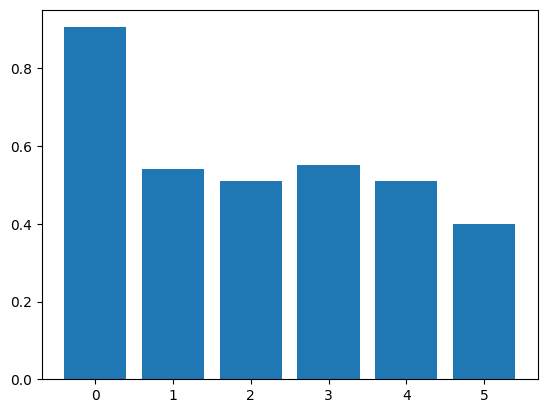

In [ ]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [38]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

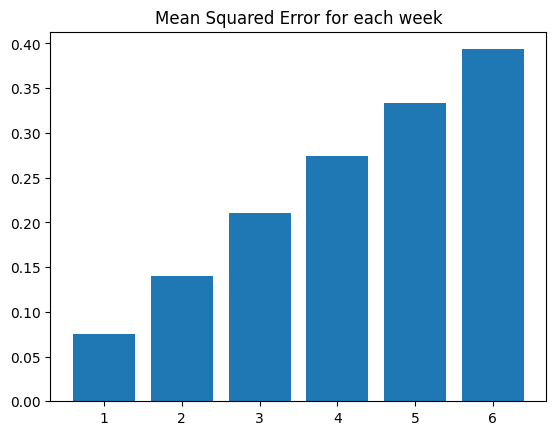

In [ ]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

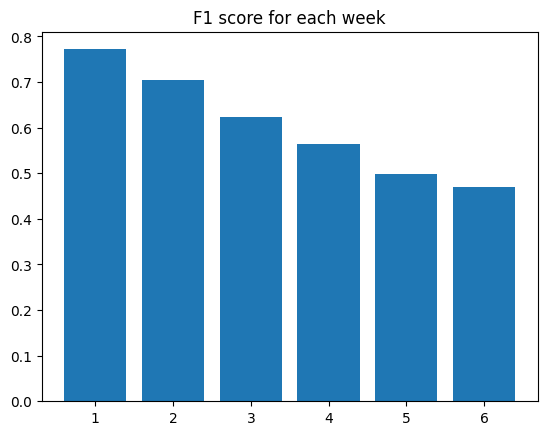

In [ ]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

(array([1.20000e+01, 3.60000e+01, 2.50000e+01, 2.20000e+01, 2.10000e+01,
        4.70000e+01, 3.70000e+01, 6.20000e+01, 1.00000e+02, 1.41000e+02,
        1.72000e+02, 1.90000e+02, 3.49000e+02, 5.64000e+02, 7.78000e+02,
        1.05400e+03, 1.94300e+03, 3.86600e+03, 6.31900e+03, 1.19100e+04,
        4.42360e+04, 1.29072e+05, 3.35360e+04, 1.43340e+04, 1.08310e+04,
        1.00990e+04, 4.03500e+03, 2.15900e+03, 1.46300e+03, 1.11300e+03,
        6.10000e+02, 2.74000e+02, 1.34000e+02, 1.21000e+02, 8.50000e+01,
        5.80000e+01, 1.00000e+01, 1.60000e+01, 8.00000e+00, 2.20000e+01]),
 array([-4.8411212 , -4.61840219, -4.39568318, -4.17296418, -3.95024517,
        -3.72752617, -3.50480716, -3.28208815, -3.05936915, -2.83665014,
        -2.61393113, -2.39121213, -2.16849312, -1.94577412, -1.72305511,
        -1.5003361 , -1.2776171 , -1.05489809, -0.83217908, -0.60946008,
        -0.38674107, -0.16402207,  0.05869694,  0.28141595,  0.50413495,
         0.72685396,  0.94957297,  1.17229197,  1

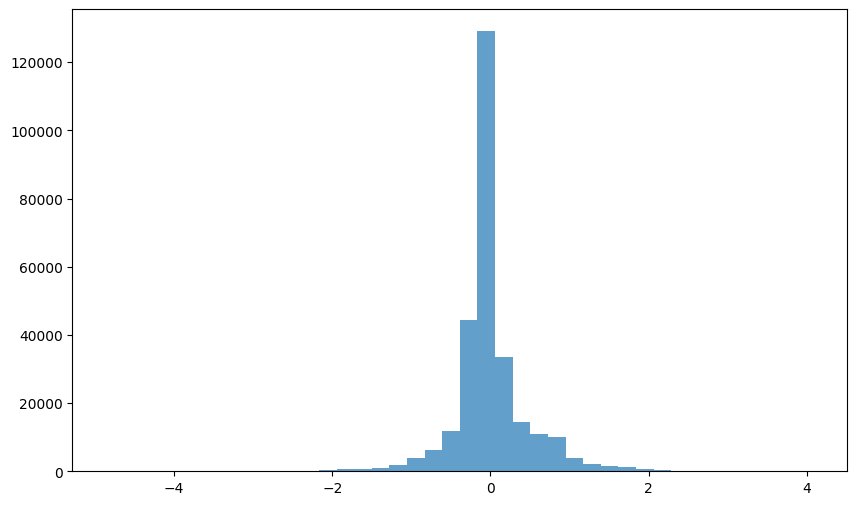

In [ ]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

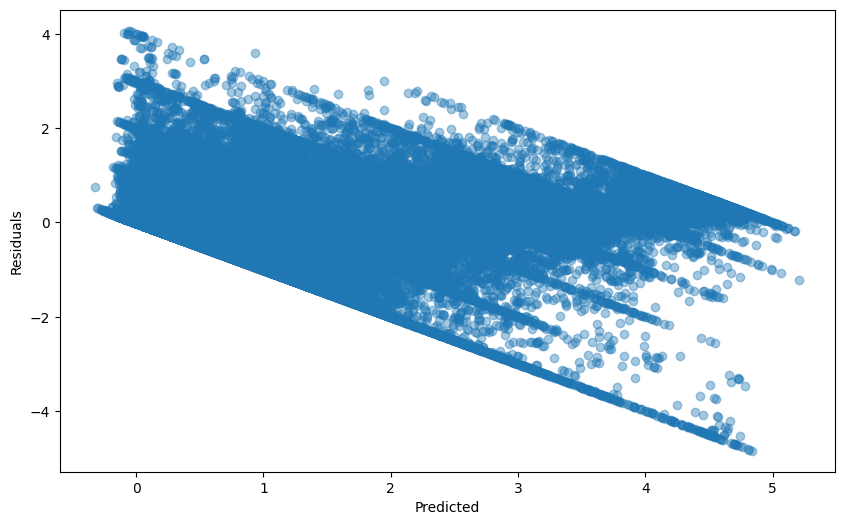

In [ ]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

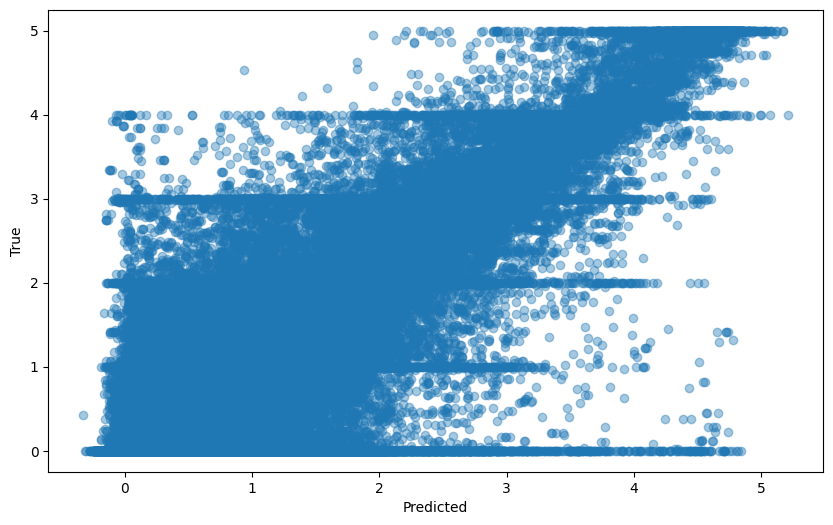

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")